In [9]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import jieba
from jieba import analyse
import itertools
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
sentence = '我爱北京天安门'
words = list(jieba.cut(sentence))
words

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/mt/9xr9vc1j62s6yvdx48jm0xlr0000gn/T/jieba.cache
Loading model cost 0.553 seconds.
Prefix dict has been built successfully.


['我', '爱', '北京', '天安门']

In [8]:
class Trie:
    def __init__(self):
        self.root = {}
        self.end = -1

    def insert(self, word):
        node = self.root
        for char in word:
            node = node.setdefault(char, {})
        node[self.end] = self.end

    def search(self, word):
        node = self.root
        for char in word:
            if char not in node:
                return False
            node = node[char]
        return self.end in node

    def startsWith(self, prefix):
        node = self.root
        for char in prefix:
            if char not in node:
                return False
            node = node[char]
        return True

t = Trie()
t.insert('我')
t.insert('爱')
t.insert('北京')
t.insert('天安门')

print(t.root)

def get_DAG(sentence, trie):
    DAG = {}
    N = len(sentence)
    for k in range(N):
        tmplist = []
        i = k
        frag = sentence[k]
        while i < N and trie.startsWith(frag):
            if trie.search(frag):
                tmplist.append(i)
            i += 1
            frag = sentence[k:i+1]
        if not tmplist:
            tmplist.append(k)
        DAG[k] = tmplist
    return DAG
    
print(get_DAG(sentence, t))

{'我': {-1: -1}, '爱': {-1: -1}, '北': {'京': {-1: -1}}, '天': {'安': {'门': {-1: -1}}}}
{0: [0], 1: [1], 2: [3], 3: [3], 4: [6], 5: [5], 6: [6]}


In [10]:
jieba.analyse.extract_tags(sentence, topK=5, withWeight=True)

[('天安门', 4.49770143677), ('北京', 2.33370115436)]

In [17]:
neg_inf = -3.14e+100

# States (Begin, Middle, End, Single character)
states = ['B', 'M', 'E', 'S']

# Observations - Characters in Sentence
observations = ['我', '喜', '欢', '北', '京', '天', '安', '门', '广', '场']

# Probability of starting in a particular state
start_p = {'B': -0.263, 'M': neg_inf, 'E': neg_inf, 'S': -1.465}

# Probability of transitioning from one state to another
trans_p = {
    'B': {'B': neg_inf, 'E': -0.916, 'M': -0.809, 'S': neg_inf},
    'E': {'B': -0.333, 'E': neg_inf, 'M': neg_inf, 'S': -0.721},
    'M': {'B': neg_inf, 'E': -1.26, 'M': -0.587, 'S': neg_inf},
    'S': {'B': -0.721, 'E': neg_inf, 'M': neg_inf, 'S': -0.666}
}

# Probability of a state emitting a particular character
emit_p = {
    'B': {'我': -5.7, '喜': -2.7, '欢': -6.0, '北': -4.4, '京': -2.6, '天': -0.5, '安': -5.4, '门': -4.4, '广': -0.6, '场': -0.8},
    'M': {'我': -7.4, '喜': -5.5, '欢': -5.7, '北': -6.5, '京': -4.8, '天': -4.6, '安': -2.9, '门': -3.6, '广': -0.5, '场': -0.5},
    'E': {'我': -3.4, '喜': -6.5, '欢': -2.7, '北': -7.5, '京': -2.8, '天': -3.6, '安': -4.9, '门': -1.6, '广': -0.5, '场': -0.5},
    'S': {'我': -0.6, '喜': -4.8, '欢': -3.5, '北': -5.5, '京': -3.8, '天': -2.8, '安': -2.7, '门': -5.5, '广': -0.5, '场': -0.5}
}

def viterbi(obs, states, start_p, trans_p, emit_p):
    path = {}
    # Initialize base cases (t == 0)
    V = [{}]
    for state in states:
        V[0][state] = start_p[state] + emit_p[state].get(obs[0], neg_inf)
        path[state] = [state]

    # Run Viterbi for t > 0
    for t in range(1, len(obs)):
        V.append({})
        newpath = {}

        for state in states:
            (prob, state_max) = max(
                [(V[t-1][prev_state] + trans_p[prev_state].get(state, neg_inf) + emit_p[state].get(obs[t], neg_inf), prev_state) for prev_state in states]
            )
            V[t][state] = prob
            newpath[state] = path[state_max] + [state]

        path = newpath

    # Find the final most probable state
    (prob, state_max) = max([(V[len(obs) - 1][state], state) for state in states])
    return (prob, path[state_max])

# Observations for the sentence '我喜欢北京天安门广场'
observations = ['我', '喜', '欢', '北', '京', '天', '安', '门', '广', '场']

prob, state_path = viterbi(observations, states, start_p, trans_p, emit_p)
print("Probability of the best path:", prob)
print("Best path (state sequence):", state_path)

# Convert state sequence to segmented words
def segment(sentence, state_path):
    words = []
    word = ''
    for char, state in zip(sentence, state_path):
        if state in ['B', 'M']:
            word += char
        elif state in ['E', 'S']:
            word += char
            words.append(word)
            word = ''
    return words

sentence = '我喜欢北京天安门广场'
segmented_words = segment(sentence, state_path)
print("Segmented Words:", segmented_words)


Probability of the best path: -27.195000000000004
Best path (state sequence): ['S', 'B', 'E', 'B', 'E', 'B', 'M', 'E', 'B', 'M']
Segmented Words: ['我', '喜欢', '北京', '天安门']


HMM 分词
- https://blog.csdn.net/u014365862/article/details/54891582

In [8]:
# Example
sentences = [
    ["I", "enjoy", "learning", "new", "things"],
    ["learning", "new", "skills", "is", "enjoyable"],
    ["things", "to", "learn", "are", "new"],]
vocab = list(set([word for sentence in sentences for word in sentence]))
word_to_idx = {w: idx for (idx, w) in enumerate(vocab)}
idx_to_word = {idx: w for (idx, w) in enumerate(vocab)}

# Hyperparameters (+ window size)
embedding_dim = 5
learning_rate = 0.01
epochs = 1000
window_size = 2

# Initialize embeddings
input_embeddings = np.random.normal(size=(len(vocab), embedding_dim))
output_embeddings = np.random.normal(size=(len(vocab), embedding_dim))

# Softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Forward pass for CBOW
def cbow_forward(context_words, target_word):
    context_ids = [word_to_idx[word] for word in context_words]
    target_id = word_to_idx[target_word]
    
    context_vectors = input_embeddings[context_ids]
    avg_context_vector = np.mean(context_vectors, axis=0)
    
    scores = np.dot(output_embeddings, avg_context_vector)
    probs = softmax(scores)
    
    return probs, target_id

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for sentence in sentences:
        for i in range(1, len(sentence) - 1):
            context = [sentence[i - 1], sentence[i + 1]]
            target = sentence[i]
            
            probs, target_id = cbow_forward(context, target)
            
            loss = -np.log(probs[target_id])
            total_loss += loss
            
            # Backpropagation
            grad_output = probs.copy()
            grad_output[target_id] -= 1
            
            context_ids = [word_to_idx[word] for word in context]
            avg_context_vector = np.mean(input_embeddings[context_ids], axis=0)
            
            grad_output_embeddings = np.outer(grad_output, avg_context_vector)
            grad_input_embeddings = np.dot(grad_output, output_embeddings)
            
            # Update input embeddings
            for context_id in context_ids:
                input_embeddings[context_id] -= learning_rate * grad_input_embeddings / len(context)
            
            # Update output embeddings
            output_embeddings -= learning_rate * grad_output_embeddings
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

# Retrieve embeddings
for word in vocab:
    print(f"Word: {word}, Embedding: {input_embeddings[word_to_idx[word]]}")


Epoch 0, Loss: 48.96553622799411
Epoch 100, Loss: 9.78748373390922
Epoch 200, Loss: 4.219368974106241
Epoch 300, Loss: 2.2802055721591206
Epoch 400, Loss: 1.3229484116830557
Epoch 500, Loss: 0.8171952524264806
Epoch 600, Loss: 0.5507592615045269
Epoch 700, Loss: 0.4019853524481169
Epoch 800, Loss: 0.31138808505796906
Epoch 900, Loss: 0.2517663079504325
Word: new, Embedding: [ 1.10042015 -1.79268926  1.22446801 -1.25591048  1.43569471]
Word: learning, Embedding: [ 3.86329533  0.81703764 -0.62207005  1.09405072 -0.51975627]
Word: things, Embedding: [-0.52792259  0.14902426 -1.63580956  0.67300573 -2.04859315]
Word: I, Embedding: [ 0.58092293 -0.38298503 -1.2124446   0.74873268  2.43993875]
Word: enjoyable, Embedding: [-0.99971616  0.40868372  0.27342075 -1.42356802  0.49274823]
Word: is, Embedding: [ 1.53842676  1.46484277  1.13963904 -2.59253229  0.75280932]
Word: skills, Embedding: [-1.54014431  2.73111248  0.28345323  0.92155911 -0.74487687]
Word: learn, Embedding: [-0.88317221  0.212

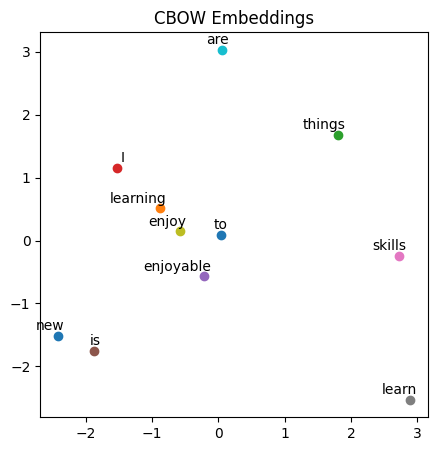

In [9]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(input_embeddings)

# Visualize the embeddings
plt.figure(figsize=(5, 5))
for word in vocab:
    idx = word_to_idx[word]
    x, y = reduced_embeddings[idx]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',
                 ha='right', va='bottom')
plt.title('CBOW Embeddings')
plt.show()

In [10]:
# Example
sentences = [
    ["I", "enjoy", "learning", "new", "things"],
    ["learning", "new", "skills", "is", "enjoyable"],
    ["things", "to", "learn", "are", "new"],]
vocab = list(set([word for sentence in sentences for word in sentence]))
word_to_idx = {w: idx for (idx, w) in enumerate(vocab)}
idx_to_word = {idx: w for (idx, w) in enumerate(vocab)}

# Hyperparameters (+ window size)
embedding_dim = 5
learning_rate = 0.01
epochs = 1000
window_size = 2

# Initialize embeddings
input_embeddings = np.random.normal(size=(len(vocab), embedding_dim))
output_embeddings = np.random.normal(size=(len(vocab), embedding_dim))

# Softmax function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Forward pass for Skip-Gram
def skip_gram_forward(target_word, context_word):
    target_id = word_to_idx[target_word]
    context_id = word_to_idx[context_word]
    
    target_vector = input_embeddings[target_id]
    
    scores = np.dot(output_embeddings, target_vector)
    probs = softmax(scores)
    
    return probs, context_id

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for sentence in sentences:
        for i, target in enumerate(sentence):
            context_ids = list(range(max(0, i - window_size), min(len(sentence), i + window_size + 1)))
            context_ids.remove(i)  # Remove the target word index

            for j in context_ids:
                context = sentence[j]
                
                probs, context_id = skip_gram_forward(target, context)
                
                loss = -np.log(probs[context_id])
                total_loss += loss
                
                # Backpropagation
                grad_output = probs.copy()
                grad_output[context_id] -= 1
                
                grad_input_embeddings = np.dot(output_embeddings.T, grad_output)
                grad_output_embeddings = np.outer(grad_output, input_embeddings[word_to_idx[target]])
                
                input_embeddings[word_to_idx[target]] -= learning_rate * grad_input_embeddings
                output_embeddings -= learning_rate * grad_output_embeddings
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

# Retrieve embeddings
for word in vocab:
    print(f"Word: {word}, Embedding: {input_embeddings[word_to_idx[word]]}")


Epoch 0, Loss: 147.44285265577037
Epoch 100, Loss: 78.32991317021985
Epoch 200, Loss: 70.64518416082525
Epoch 300, Loss: 65.91117376724954
Epoch 400, Loss: 63.39330582583715
Epoch 500, Loss: 62.30906046418392
Epoch 600, Loss: 61.6260969299163
Epoch 700, Loss: 61.131520356351565
Epoch 800, Loss: 60.86580064946543
Epoch 900, Loss: 60.74163755852423
Word: new, Embedding: [-0.48101563 -0.5336324   1.7907517  -0.40026335 -0.0918731 ]
Word: learning, Embedding: [ 2.1399475   0.81566788  0.05946687 -1.77692542 -0.73091819]
Word: things, Embedding: [-2.17364221  0.73836692 -1.92481649 -0.78651881  1.18216909]
Word: I, Embedding: [ 1.53576478 -0.82165053  2.17677276  1.07731409  3.17408828]
Word: enjoyable, Embedding: [ 1.89784574 -2.73088433 -1.27311069 -0.59673628  1.43537685]
Word: is, Embedding: [ 1.75953904 -1.93067758 -2.845543    1.3387322  -0.73589416]
Word: skills, Embedding: [ 0.12594054 -1.33999167 -2.09329294  0.4266562   1.72227843]
Word: learn, Embedding: [ 0.93078524  2.19085448 

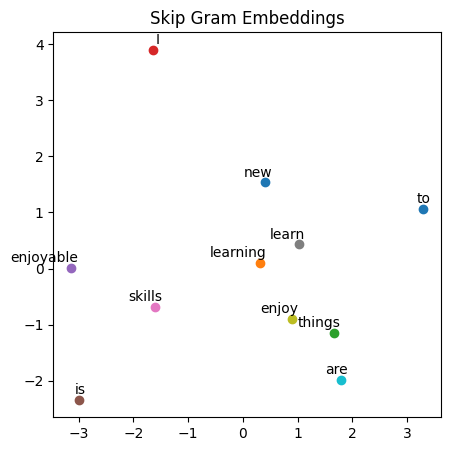

In [11]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(input_embeddings)

# Visualize the embeddings
plt.figure(figsize=(5, 5))
for word in vocab:
    idx = word_to_idx[word]
    x, y = reduced_embeddings[idx]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',
                 ha='right', va='bottom')
plt.title('Skip Gram Embeddings')
plt.show()

           I  enjoy  learning  new  things  skills  is  enjoyable  to  learn  \
enjoy      1      0         1    0       0       0   0          0   0      0   
learning   0      1         0    2       0       0   0          0   0      0   
I          0      1         0    0       0       0   0          0   0      0   
new        0      0         2    0       1       1   0          0   0      0   
things     0      0         0    1       0       0   0          0   1      0   
skills     0      0         0    1       0       0   1          0   0      0   
is         0      0         0    0       0       1   0          1   0      0   
learn      0      0         0    0       0       0   0          0   1      0   
are        0      0         0    1       0       0   0          0   0      1   
to         0      0         0    0       1       0   0          0   0      1   
enjoyable  0      0         0    0       0       0   1          0   0      0   

           are  
enjoy        0  
learn

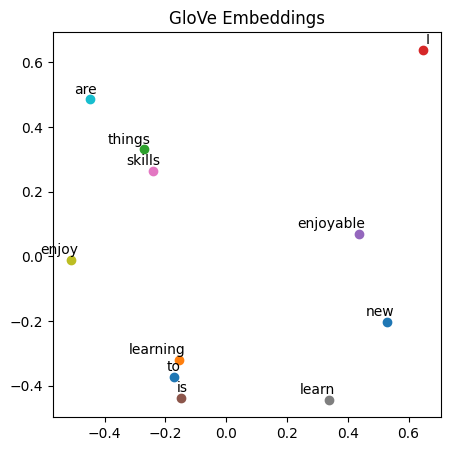

In [13]:
# Sample larger corpus
sentences = [
    ["I", "enjoy", "learning", "new", "things"],
    ["learning", "new", "skills", "is", "enjoyable"],
    ["things", "to", "learn", "are", "new"],
]

# Vocabulary
vocab = list(set(itertools.chain(*sentences)))
word_to_idx = {w: idx for idx, w in enumerate(vocab)}
idx_to_word = {idx: w for idx, w in enumerate(vocab)}

# Hyperparameters
window_size = 2
embedding_dim = 5
learning_rate = 0.01
epochs = 100

# Build co-occurrence matrix
co_occurrence = defaultdict(lambda: defaultdict(int))

for sentence in sentences:
    for i, word in enumerate(sentence):
        word_id = word_to_idx[word]
        start = max(i - window_size, 0)
        end = min(i + window_size + 1, len(sentence))
        
        for j in range(start, end):
            if i != j:
                context_word_id = word_to_idx[sentence[j]]
                co_occurrence[word_id][context_word_id] += 1 / abs(i - j)  # Decaying weight

# Convert to DataFrame for better readability
co_occurrence_matrix = pd.DataFrame(co_occurrence).fillna(0).astype(int)
co_occurrence_matrix.index = [idx_to_word[idx] for idx in co_occurrence_matrix.index]
co_occurrence_matrix.columns = [idx_to_word[idx] for idx in co_occurrence_matrix.columns]
print(co_occurrence_matrix)

# Define the GloVe loss function
def glove_loss(vocab_size, co_occurrence, word_vectors, biases, x_max=100, alpha=0.75):
    loss = 0.0
    for i in range(vocab_size):
        for j in range(vocab_size):
            if co_occurrence[i][j] > 0:
                weight = (co_occurrence[i][j] / x_max) ** alpha if co_occurrence[i][j] < x_max else 1
                diff = np.dot(word_vectors[i], word_vectors[j]) + biases[i] + biases[j] - np.log(co_occurrence[i][j])
                loss += weight * (diff ** 2)
    return loss

# Train GloVe model
def train_glove(sentences, vocab, word_to_idx, embedding_dim=50, learning_rate=0.01, epochs=100):
    vocab_size = len(vocab)
    word_vectors = np.random.rand(vocab_size, embedding_dim)
    biases = np.random.rand(vocab_size)

    # Initialize co-occurrence matrix
    co_occurrence = defaultdict(lambda: defaultdict(int))
    for sentence in sentences:
        for i, word in enumerate(sentence):
            word_id = word_to_idx[word]
            start = max(i - window_size, 0)
            end = min(i + window_size + 1, len(sentence))
            for j in range(start, end):
                if i != j:
                    context_word_id = word_to_idx[sentence[j]]
                    co_occurrence[word_id][context_word_id] += 1 / abs(i - j)

    for epoch in range(epochs):
        total_loss = glove_loss(vocab_size, co_occurrence, word_vectors, biases)
        
        for i in range(vocab_size):
            for j in range(vocab_size):
                if co_occurrence[i][j] > 0:
                    weight = (co_occurrence[i][j] / 100) ** 0.75 if co_occurrence[i][j] < 100 else 1
                    diff = np.dot(word_vectors[i], word_vectors[j]) + biases[i] + biases[j] - np.log(co_occurrence[i][j])
                    grad_wi = 2 * weight * diff * word_vectors[j]
                    grad_wj = 2 * weight * diff * word_vectors[i]
                    grad_bi = 2 * weight * diff
                    grad_bj = 2 * weight * diff

                    word_vectors[i] -= learning_rate * grad_wi
                    word_vectors[j] -= learning_rate * grad_wj
                    biases[i] -= learning_rate * grad_bi
                    biases[j] -= learning_rate * grad_bj

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss}")

    return word_vectors

# Train GloVe
word_vectors = train_glove(sentences, vocab, word_to_idx, embedding_dim=5, learning_rate=0.01, epochs=100)

# Reduce dimensions with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(word_vectors)

# Visualize the embeddings
plt.figure(figsize=(5, 5))
for word in vocab:
    idx = word_to_idx[word]
    x, y = reduced_embeddings[idx]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',
                 ha='right', va='bottom')
plt.title('GloVe Embeddings')
plt.show()
